# Modelo Variational Autoencoder (VAE) para Reconstrucción de Imágenes

El archivo se encarga de implementar un modelo **`Variational Autoencoder (VAE)`** para la reconstrucción de imágenes. A continuación se presenta la documentación del código proporcionado:

## Introducción

El **`Variational Autoencoder (VAE)`** es un tipo de red neuronal generativa que permite modelar la distribución de datos de entrada y generar muestras nuevas similares a los datos de entrenamiento. En este caso, se utiliza un **`VAE`** para la reconstrucción de imágenes de espectrogramas de audio de aves.

## Bibliotecas Utilizadas

- **`Keras`**: Biblioteca de aprendizaje profundo utilizada para la implementación de modelos de redes neuronales.
- **`TensorFlow`**: Plataforma de código abierto para el aprendizaje automático.
- **`NumPy`**: Biblioteca utilizada para cálculos numéricos en Python.
- **`Pandas`**: Utilizada para el manejo de datos tabulares.
- **`scikit-learn`**: Biblioteca de aprendizaje automático que incluye diversas herramientas para el análisis de datos y modelado estadístico.
- **`PIL (Python Imaging Library)`**: Utilizada para el procesamiento de imágenes.
- **`Matplotlib`**: Biblioteca utilizada para la visualización de datos y gráficos.

## Funcionalidades Principales

1. **Definición del Modelo VAE**:
   - Se utiliza la API funcional de **`Keras`** para definir el modelo **`VAE`**, que consta de un codificador, un espacio latente y un decodificador.

2. **Implementación de la Función de Pérdida**:
   - Se implementa la función de pérdida del **`VAE`**, que consiste en la suma de la pérdida de reconstrucción y la divergencia KL (Kullback-Leibler).

3. **Entrenamiento del Modelo**:
   - Se entrena el modelo **`VAE`** utilizando datos de entrenamiento de imágenes de espectrogramas de audio.

4. **Evaluación del Modelo**:
   - Se evalúa el rendimiento del modelo **`VAE`** utilizando métricas de evaluación de reconstrucción de imágenes.

## Contribuciones Esperadas

Se espera que este archivo contribuya a la implementación y entrenamiento exitoso de un modelo **`VAE`** para la reconstrucción de imágenes de espectrogramas de audio de aves. El modelo entrenado podrá utilizarse posteriormente para la generación de nuevas muestras de espectrogramas de audio, lo que puede ser útil en diversas aplicaciones relacionadas con el análisis de sonido de aves y la bioacústica.


In [35]:
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
from keras import layers
from keras.losses import mse
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Cropping2D
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from collections import Counter
from PIL import Image
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Preparación de Datos

1. **Inicialización de Listas**: Se inicializan las listas `paths_imagenes` y `nombres_clases` para almacenar los paths de las imágenes y los nombres de las clases, respectivamente.

2. **Recorrido de Archivos en la Carpeta**: Se recorren los archivos en la carpeta especificada (`carpeta_dataset`). Para cada archivo, se verifica si es una imagen (con extensión .jpeg) y se extrae el nombre de la clase.

3. **Procesamiento de Imágenes**: Se carga cada imagen utilizando la biblioteca PIL (Python Imaging Library) y se agrega a la lista `log_spectograms`. Si es necesario, se pueden realizar preprocesamientos adicionales en esta etapa.

4. **Codificación de Etiquetas**: Se utiliza `LabelEncoder` para asignar un número único a cada etiqueta de clase. Luego, se convierten las etiquetas a representación categórica utilizando `to_categorical` de Keras.

5. **División del Conjunto de Datos**: Se divide el conjunto de datos en conjuntos de entrenamiento (80%) y validación (20%) utilizando `train_test_split`.

6. **Mostrar Información del Conjunto de Datos**: Se imprime el número de muestras en cada conjunto de datos.


In [4]:
carpeta_dataset = 'Dataset-Images-Mel'

# Inicializar listas para almacenar paths de imágenes y nombres de clases
paths_imagenes = []
nombres_clases = []

# Recorrer los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_dataset):
    # Obtener la ruta completa del archivo
    path_completo = os.path.join(carpeta_dataset, nombre_archivo)
    
    # Verificar si es un archivo y si es una imagen (puedes ajustar esta condición según tus necesidades)
    if os.path.isfile(path_completo) and nombre_archivo.lower().endswith('.jpeg'):
        # Dividir el nombre del archivo para obtener la clase y añadir a las listas
        partes_nombre = os.path.splitext(nombre_archivo)[0].split('_')
        nombre_clase = partes_nombre[0]
        
        paths_imagenes.append(path_completo)
        nombres_clases.append(nombre_clase)

log_spectograms = []
for path in paths_imagenes:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen a la lista
    log_spectograms.append(image)

log_spectograms = np.array(log_spectograms)

# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nombres_clases)

# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(nombres_clases)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(log_spectograms, nombres_clases, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(log_spectograms)}")
print(f"Número de muestras de clases: {len(nombres_clases)}")


Número de muestras de entrenamiento: 5590
Número de muestras de clases: 5590


In [3]:
carpeta_dataset = 'Dataset-Images-Mel'
cantidad_por_clase = 136  # Ajusta esta variable según tus necesidades

# Inicializar listas para almacenar paths de imágenes y nombres de clases
paths_imagenes = []
nombres_clases = []

# Contador para rastrear la cantidad de imágenes por clase
conteo_por_clase = {}

# Recorrer los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta_dataset):
    # Obtener la ruta completa del archivo
    path_completo = os.path.join(carpeta_dataset, nombre_archivo)
    
    # Verificar si es un archivo y si es una imagen (puedes ajustar esta condición según tus necesidades)
    if os.path.isfile(path_completo) and nombre_archivo.lower().endswith('.jpeg'):
        # Dividir el nombre del archivo para obtener la clase y añadir a las listas
        partes_nombre = os.path.splitext(nombre_archivo)[0].split('_')
        nombre_clase = partes_nombre[0]
        
        # Verificar el conteo de imágenes por clase
        if nombre_clase not in conteo_por_clase:
            conteo_por_clase[nombre_clase] = 0
        
        # Si no hemos alcanzado la cantidad deseada por clase, añadir la imagen
        if conteo_por_clase[nombre_clase] < cantidad_por_clase:
            paths_imagenes.append(path_completo)
            nombres_clases.append(nombre_clase)
            conteo_por_clase[nombre_clase] += 1

log_spectograms = []
for path in paths_imagenes:
    image = Image.open(path)
    # Puedes realizar cualquier preprocesamiento adicional aquí si es necesario
    image = np.array(image)  # Convertir a formato NumPy si estás utilizando TensorFlow
    # Agregar la imagen a la lista
    log_spectograms.append(image)

log_spectograms = np.array(log_spectograms)
# Utilizar LabelEncoder para asignar un número único a cada etiqueta
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(nombres_clases)

# Convertir a representación categórica
categorical_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=len(set(nombres_clases)))

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
train_data, val_data, train_labels, val_labels = train_test_split(log_spectograms, nombres_clases, test_size=0.2, random_state=42)

# Mostrar el número de muestras en cada conjunto
print(f"Número de muestras de entrenamiento: {len(train_data)}")
print(f"Número de muestras de clases: {len(train_labels)}")


Número de muestras de entrenamiento: 1414
Número de muestras de clases: 1414


In [5]:
print(f"Forma de train_data: {log_spectograms.shape}")

Forma de train_data: (5590, 224, 224, 3)


## Visualización de Imágenes

1. **Selección de Imágenes**: Se seleccionan las primeras **`num_imagenes_a_mostrar`** imágenes de la lista de espectrogramas **`log_spectograms`**.

2. **Configuración del Diseño de Visualización**: Se configura el diseño de la visualización utilizando **`plt.subplots`** para crear una matriz de subplots.

3. **Visualización de Cada Imagen**: Se visualiza cada imagen en su respectivo subplot. Se utiliza **`imshow`** de Matplotlib para mostrar la imagen en formato de matriz. Se configura el colormap a **`'gray'`** para imágenes en escala de grises. Se elimina el eje de coordenadas con **`axis('off')`** y se asigna un título a cada subplot con el número de espectrograma correspondiente.

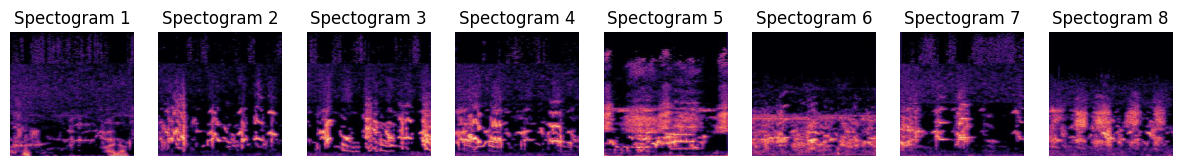

In [6]:
# Seleccionar algunas imágenes para visualizar
num_imagenes_a_mostrar = 8
imagenes_a_mostrar = log_spectograms[:num_imagenes_a_mostrar]

# Configurar el diseño de la visualización
fig, axes = plt.subplots(1, num_imagenes_a_mostrar, figsize=(15, 5))

# Visualizar cada imagen
for i in range(num_imagenes_a_mostrar):
    axes[i].imshow(np.squeeze(imagenes_a_mostrar[i]), cmap='gray')  # cmap='gray' para imágenes en escala de grises
    axes[i].axis('off')
    axes[i].set_title(f'Spectogram {i + 1}')

plt.show()


In [8]:
# Now you can check GPU information
tf.config.list_physical_devices('GPU')
tf.config.experimental.reset_memory_stats('GPU:0')
!nvidia-smi
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
  print(tf.config.experimental.get_memory_info('GPU:0'))

Tue Jan 23 16:43:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P2              27W / 285W |   1099MiB / 12282MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Normalización de Valores de Píxeles

1. **Normalización de Valores**: Se convierte el conjunto de datos de entrenamiento (**`train_data`**) y el conjunto de datos completo (**`log_spectograms`**) a tipo de datos `float32` y se divide cada valor de píxel por 255.0 para normalizar los valores entre 0 y 1.

In [ ]:
# Normalize pixel values between 0 and 1
x_train = np.array(train_data).astype('float32') / 255.0
x_latent_representation = np.array(log_spectograms).astype('float32') / 255.0
x_latent_representation.shape

## Formato de Entrada y Dimensión Latente

1. **Formato de Entrada**: Se define el tamaño de las imágenes de entrada como **`224x224x3`** mediante la variable **`input_shape`**.

2. **Dimensión Latente**: Se especifica la dimensión latente del espacio latente como **`1200`** a través de la variable **`latent_dim`**.

## Red Neuronal del Codificador

1. **Capas Convolucionales**: Se definen varias capas convolucionales con activación ReLU y diferentes parámetros (tamaño del filtro, pasos y relleno) para extraer características de las imágenes de entrada.

2. **Aplanado**: Se aplica una capa de aplanado para convertir la salida de las capas convolucionales en un vector unidimensional.

3. **Capas de Salida**: Se definen dos capas densas para calcular los parámetros de la distribución en el espacio latente, que son la media (**`z_mean`**) y la desviación estándar (**`z_log_var`**).

In [10]:
# Define input shape and latent dimension
img_size = 224
latent_dim = 1200
input_shape = (224, 224, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu',strides = 2,  padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu',strides = 2, padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', strides = 2,padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', strides = 2, padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

## Función de Muestreo

1. **Definición de la Función**: Se define una función llamada **`sampling`** que toma como argumentos los vectores de media (**`z_mean`**) y de log-varianza (**`z_log_var`**).

2. **Muestreo Aleatorio**: Se genera un vector de ruido aleatorio utilizando la distribución normal estándar y se escala según la desviación estándar del espacio latente. Luego, se suma a la media para obtener muestras del espacio latente.

In [11]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

## Red Neuronal del Decodificador

1. **Entrada del Decodificador**: Se define una capa de entrada con la forma del espacio latente.

2. **Capas Densas y de Reshape**: Se aplica una capa densa seguida de una capa de reshape para transformar la entrada del decodificador en un tensor con la forma apropiada para las capas convolucionales.

3. **Capas de Transposición Convolucional**: Se definen varias capas de transposición convolucional con activación ReLU y diferentes parámetros (tamaño del filtro, pasos y relleno) para generar la reconstrucción de la imagen.

4. **Capa de Salida**: Se define una capa convolucional con activación sigmoide para producir la salida final, que representa la imagen reconstruida.


In [12]:
# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', strides = 2, padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu',strides = 2, padding='same')(x)
x = Conv2DTranspose(32, (2, 2), activation='relu',strides = 2, padding='same')(x)
x = Conv2DTranspose(16, (2, 2), activation='relu',strides = 2, padding='same')(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [13]:
num_features = shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3]
num_features

25088

El siguiente código define el modelo del Autoencoder Variacional (VAE), que consiste en un codificador, un decodificador y la combinación de ambos. A continuación se presenta la documentación correspondiente:

**`Modelo del Codificador`**: Se define el modelo del codificador utilizando la entrada original como entrada y las salidas del vector de media, el vector de log-varianza y las muestras del espacio latente como salidas.

**`Modelo del Decodificador`**: Se define el modelo del decodificador utilizando las muestras del espacio latente como entrada y produciendo la reconstrucción de la imagen como salida.

**`Combinación del Codificador y Decodificador`**: Se define el modelo VAE combinando el codificador y el decodificador. La entrada del VAE es la entrada original y la salida es la reconstrucción de la imagen.


In [14]:
# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [15]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 1200),            60311040  
                              (None, 1200),                      
                              (None, 1200)]                      
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       30239907  
                                                                 
Total params: 90,550,947
Trainable params: 90,550,947
Non-trainable params: 0
_________________________________________________________________


## Modelo VAE (Autoencoder Variacional)

- **Nombre del Modelo**: vae
- **Total de Parámetros**: 17,582,587
- **Parámetros Entrenables**: 17,582,587

## Codificador

- **Nombre del Modelo**: encoder
- **Total de Parámetros**: 60,321,040
- **Parámetros Entrenables**: 60,321,040

## Decodificador

- **Nombre del Modelo**: decoder
- **Total de Parámetros**: 30,230,107
- **Parámetros Entrenables**: 30,230,107

In [17]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 32)   4640        ['conv2d[0][0]']                 
                                                                                            

In [18]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1200)]            0         
                                                                 
 dense_2 (Dense)             (None, 25088)             30130688  
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 128)      65664     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 56, 56, 64)       32832     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 112, 112, 32)     8224

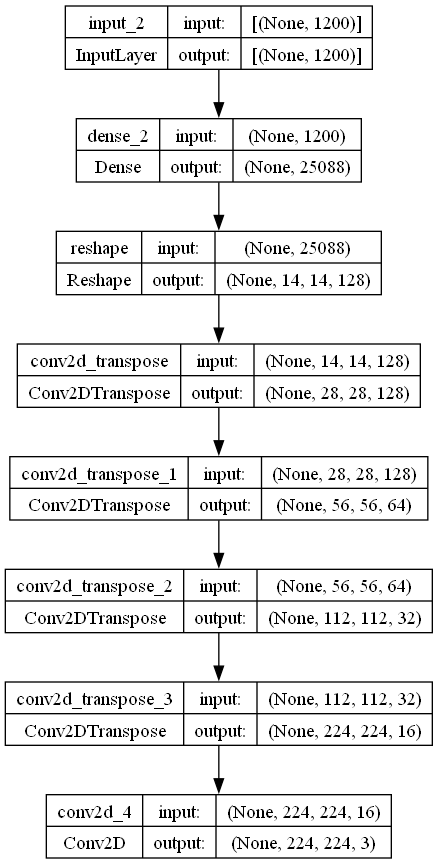

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(decoder, 'net.png', show_shapes=True)

## Función de Pérdida

1. **Pérdida de Reconstrucción**: Se calcula la pérdida de reconstrucción utilizando el error cuadrático medio (MSE) entre los datos de entrada y la salida del decodificador. Se multiplica por el número total de píxeles en una imagen para normalizar la pérdida.

2. **Pérdida de Divergencia Kullback-Leibler (KL)**: Se calcula la pérdida de divergencia KL entre la distribución latente aprendida y una distribución normal estándar.

3. **Ponderación de la Pérdida de Reconstrucción**: Se multiplica la pérdida de reconstrucción por un factor de escala (B) para equilibrar las dos pérdidas.

4. **Pérdida Total del VAE**: Se suma la pérdida de reconstrucción ponderada y la pérdida de KL para obtener la pérdida total del VAE.

5. **Adición de la Pérdida al Modelo**: Se agrega la pérdida al modelo VAE utilizando el método `add_loss`.

## Parámetro de Ponderación (B)

El parámetro **B** se utiliza para ajustar la importancia relativa de la pérdida de reconstrucción y la pérdida de KL. Puedes ajustar este valor según tus necesidades y preferencias.

In [20]:
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

## Métricas Agregadas y Optimizador

1. **Pérdida de Divergencia Kullback-Leibler (KL)**: Se agrega la pérdida de divergencia KL como una métrica al modelo VAE. Esto permite monitorear el valor de la pérdida de KL durante el entrenamiento.

2. **Pérdida de Reconstrucción**: Se agrega la pérdida de reconstrucción como una métrica al modelo VAE. Esto permite monitorear el valor de la pérdida de reconstrucción durante el entrenamiento.

3. **Optimizador**: Se utiliza el optimizador Adam con una tasa de aprendizaje de 0.0001 para compilar el modelo VAE.


In [21]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt)

## Ajuste del Modelo

In [20]:
# Ajusta el modelo VAE
# Pasar pesos para cada clase y entrenar.
vae.fit(x_latent_representation, epochs=500, batch_size=64, validation_data=(x_latent_representation, None))

Epoch 1/500
88/88 [==============================] - 15s 143ms/step - loss: 13433044.0000 - kl_loss: 51620.7969 - reconstruction_loss: 13381.5840 - val_loss: 5261105.5000 - val_kl_loss: 29121.0098 - val_reconstruction_loss: 5231.9902
Epoch 2/500
88/88 [==============================] - 10s 114ms/step - loss: 4267111.5000 - kl_loss: 32539.0566 - reconstruction_loss: 4234.5898 - val_loss: 3877437.5000 - val_kl_loss: 32010.7734 - val_reconstruction_loss: 3845.4016
Epoch 3/500
88/88 [==============================] - 10s 114ms/step - loss: 3789830.5000 - kl_loss: 28887.0332 - reconstruction_loss: 3760.9141 - val_loss: 3703624.2500 - val_kl_loss: 26800.4727 - val_reconstruction_loss: 3676.8000
Epoch 4/500
88/88 [==============================] - 10s 114ms/step - loss: 3633860.7500 - kl_loss: 24364.1621 - reconstruction_loss: 3609.5166 - val_loss: 3540775.2500 - val_kl_loss: 21533.4707 - val_reconstruction_loss: 3519.2170
Epoch 5/500
88/88 [==============================] - 10s 114ms/step - 

# Cargar los pesos a VAE

In [24]:
vae.load_weights('vae_model.h5')

## Visualización de Imágenes

1. **Tamaño de la Imagen**: Se asume que el tamaño de las imágenes es de 224x224x3 píxeles. Este valor puede ajustarse según las dimensiones de las imágenes originales.

2. **Visualización**: Se muestra un total de 10 imágenes, incluyendo la imagen original y su correspondiente reconstrucción.

3. **Subplots**: Se utilizan subplots para mostrar las imágenes originales y reconstruidas lado a lado.


In [25]:
# Convert the predictions into images
decoded_imgs = vae.predict(x_train)

140/140 [==============================] - 7s 21ms/step


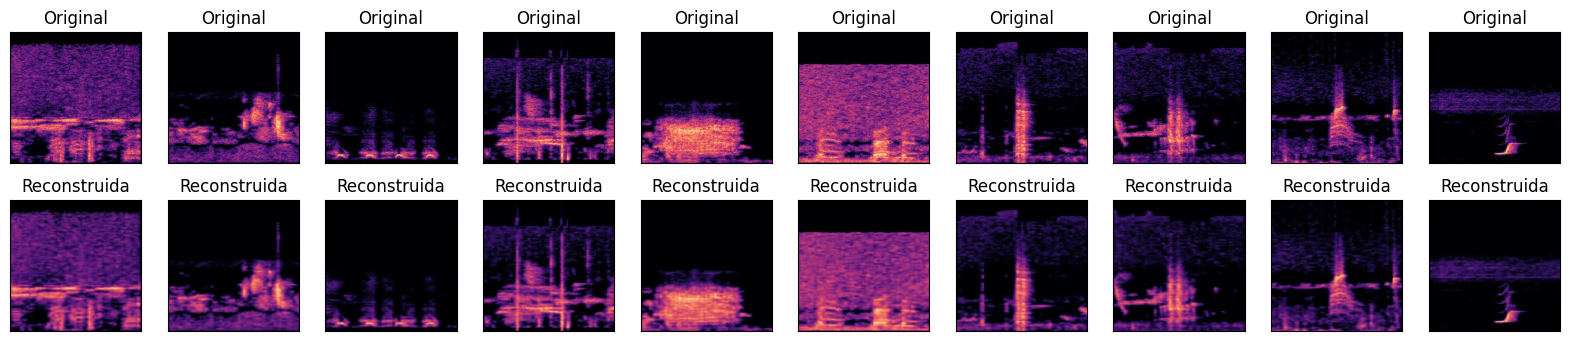

In [26]:
import matplotlib.pyplot as plt

# Display the original and reconstructed images
n = 10  # number of images to display
img_size = 224  # assuming the size of your images is 28x28x3 (adjust accordingly)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(img_size, img_size, 3))
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size, 3))
    plt.title("Reconstruida")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


# Visualización de Representaciones en el Espacio Latente

La siguiente función permite visualizar las representaciones codificadas de los datos en un gráfico de dispersión en el espacio latente. Cada punto en el gráfico representa una muestra, donde el color indica su clase.

## Función `plot_audios_encoded_in_latent_space`

Esta función toma las representaciones latentes y las etiquetas de las muestras como entrada.

- **Entrada**:
    - `latent_representations`: Representaciones latentes de las muestras.
    - `sample_labels`: Etiquetas de las muestras.

- **Funcionamiento**:
    1. Se asigna un color único a cada clase.
    2. Las muestras se visualizan en un gráfico de dispersión en el espacio latente.
    3. Se incluye una leyenda para mostrar las correspondencias entre colores y clases.


In [27]:
def plot_audios_encoded_in_latent_space(latent_representations, sample_labels):
    # Obtén una lista única de etiquetas
    unique_labels = np.unique(sample_labels)
    
    # Asigna un color único a cada etiqueta
    label_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Crea un diccionario de mapeo de etiquetas a colores
    label_to_color = dict(zip(unique_labels, label_colors))

    # Mapea las etiquetas a colores usando el diccionario
    colors = [label_to_color[label] for label in sample_labels]

    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                c=colors,
                alpha=0.5,
                s=2)
    
    # Crea una leyenda para mostrar las correspondencias entre colores y etiquetas
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=5, label=label) for label in unique_labels]
    plt.legend(handles=legend_handles, title='Labels')
    
    plt.colorbar()
    plt.show()

In [28]:
latent_representations, _, _ = encoder.predict(x_latent_representation)

175/175 [==============================] - 1s 8ms/step


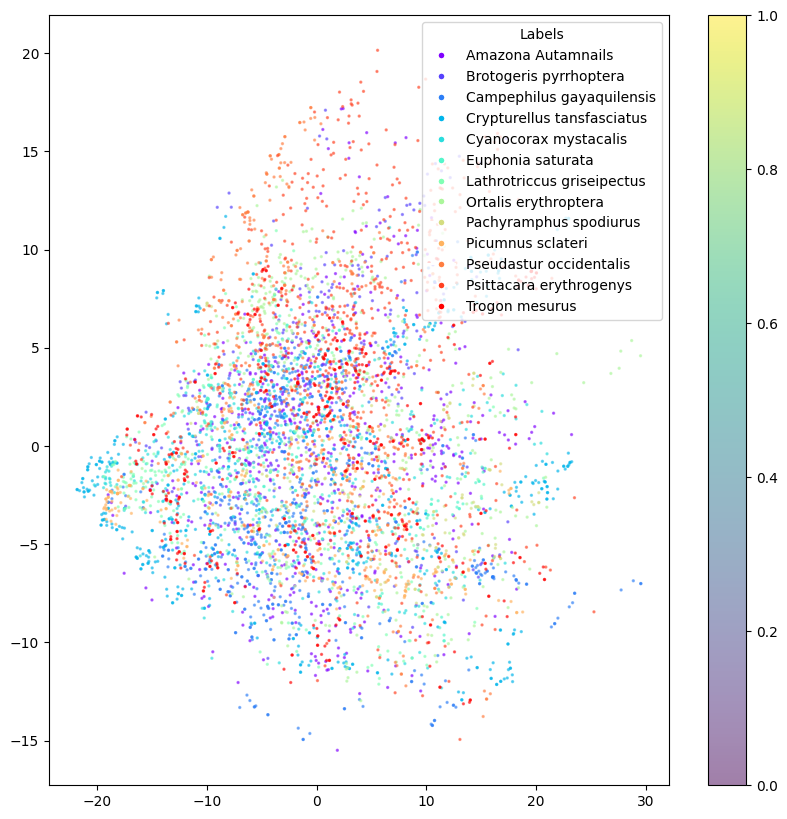

In [29]:
twodim = PCA(n_components=2).fit_transform(latent_representations)
plot_audios_encoded_in_latent_space(twodim, nombres_clases)

## Conversión de Representaciones Latentes y Etiquetas a Archivos TSV

In [36]:
# Convertir el array latent_representations a un DataFrame de pandas
latent_representations_df = pd.DataFrame(latent_representations)

# Guardar el DataFrame latent_representations en un archivo tsv
latent_representations_df.to_csv('vectors.tsv', sep='\t', index=False, header=False)

# Convertir la lista nombres_clases a un DataFrame de pandas
nombres_clases_df = pd.DataFrame({'clase': nombres_clases})

# Guardar el DataFrame nombres_clases en un archivo tsv
nombres_clases_df.to_csv('metadata.tsv', sep='\t', index=False, header=False)

# Análisis de Vectores Latentes y Distancias Coseno

Este código analiza los vectores latentes obtenidos para el conjunto de validación, centrándose en una clase específica y comparando las similitudes entre vectores de la misma clase y de otras clases.

1. **Obtención de Vectores Latentes y Organización por Clases**:
   - Se obtienen los vectores latentes para el conjunto de validación utilizando el modelo VAE.
   - Los vectores latentes se organizan por clases.

2. **Análisis de Similitudes**:
   - Se selecciona una clase específica para analizar las similitudes.
   - Se calcula la distancia coseno entre vectores de la misma clase y entre la clase seleccionada y otras clases.

3. **Resultados**:
   - Se calcula la distancia coseno promedio dentro de la clase seleccionada y entre esta clase y otras clases del conjunto de datos.


In [29]:
# Obtener vectores latentes para el conjunto de validación
latent_vectors, _, _ = encoder.predict(x_latent_representation)

# Organizar vectores latentes por clases para conjunto de validación
latent_by_class = {clase: [] for clase in set(val_labels)}
for i, clase in enumerate(val_labels):
    latent_by_class[clase].append(latent_vectors[i])

175/175 [==============================] - 1s 8ms/step


In [30]:
# Nombre de la clase a analizar
clase_a_analizar = "Brotogeris pyrrhoptera"

# Obtener los índices de las muestras correspondientes a la clase en el conjunto de validación
indices_same_class = [i for i, label in enumerate(val_labels) if label == clase_a_analizar]

# Obtener los vectores latentes correspondientes a la clase en el conjunto de validación
vectors_same_class = latent_vectors[indices_same_class]

# Calcular la distancia coseno entre vectores de la misma clase
cosine_similarities_same_class = cosine_similarity(vectors_same_class, vectors_same_class)

# Calcular la distancia coseno entre vectores de la clase a analizar y otras clases
cosine_similarities_diff_class = {}
for clase, vectors in latent_by_class.items():
    if clase != clase_a_analizar:
        cosine_similarities_diff_class[clase] = cosine_similarity(vectors_same_class, vectors)

# Análisis de resultados
mean_cosine_same_class = np.mean(cosine_similarities_same_class)
print(f"Distancia coseno promedio dentro de la clase {clase_a_analizar}: {mean_cosine_same_class}")

for other_class, cosine_similarities in cosine_similarities_diff_class.items():
    mean_cosine_diff_class = np.mean(cosine_similarities)
    print(f"Distancia coseno promedio entre la clase {clase_a_analizar} y {other_class}: {mean_cosine_diff_class}")


Distancia coseno promedio dentro de la clase Brotogeris pyrrhoptera: 0.15089581906795502
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Crypturellus tansfasciatus: 0.13585753738880157
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Cyanocorax mystacalis: 0.13620120286941528
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Euphonia saturata: 0.13542157411575317
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Lathrotriccus griseipectus: 0.14058159291744232
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Pseudastur occidentalis: 0.13857409358024597
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Trogon mesurus: 0.1398356854915619
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Campephilus gayaquilensis: 0.14126622676849365
Distancia coseno promedio entre la clase Brotogeris pyrrhoptera y Picumnus sclateri: 0.141103595495224
Distancia coseno promedio entre la clase 

# Predicción de Clases y Detección de Anomalías

Este código implementa una función para predecir la clase de una muestra o detectar anomalías en base a la distancia en el espacio latente. Utiliza un modelo de vecinos más cercanos (k-NN) entrenado con los vectores latentes de todas las clases en el conjunto de validación.

1. **Ajuste del Modelo de Vecinos Más Cercanos**:
   - Se ajusta un modelo de vecinos más cercanos utilizando los vectores latentes de todas las clases en el conjunto de validación.

2. **Predicción de Clases o Detección de Anomalías**:
   - La función `predict_class_or_detect_anomaly` predice la clase de una muestra si está dentro del umbral de distancia establecido. Si la muestra se considera una anomalía, se devuelve el valor "Anomalía".

3. **Ejemplo de Uso**:
   - Se carga una imagen y se convierte en un array de NumPy.
   - Se calcula el vector latente de la imagen utilizando el modelo VAE.
   - Se realiza una predicción utilizando la función definida.

In [31]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from PIL import Image
from collections import Counter

# Obtener los vectores latentes de todas las clases en el conjunto de validación
all_latent_vectors = latent_vectors

# Ajustar un modelo de vecinos más cercanos para todas las clases
k_neighbors = 10
nn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
nn_model.fit(all_latent_vectors)  # Ajustar el modelo con todos los vectores latentes

# Umbral para la detección de anomalías (puedes ajustar este valor según tus necesidades)
anomaly_threshold = 0.5

# Función para predecir la clase o detectar anomalías basada en la distancia en el espacio latente
def predict_class_or_detect_anomaly(latent_vector):
    # Expande las dimensiones del vector latente para que coincidan con las expectativas del modelo
    latent_vector_expanded = np.expand_dims(latent_vector, axis=0)

    # Aplana el tensor a 2D
    latent_vector_flat = latent_vector_expanded.flatten()

    # Encontrar los vecinos más cercanos
    distances, indices = nn_model.kneighbors([latent_vector_flat])
    
    # Calcular la distancia promedio de la muestra a sus k vecinos más cercanos
    average_distance = np.mean(distances)
    
    # Si la distancia es mayor que el umbral, considerar la muestra como una anomalía
    if average_distance > anomaly_threshold:
        return "Anomalía"
    else:
        # Obtener las clases correspondientes a los k vecinos más cercanos
        nearest_classes = [nombres_clases[i] for i in indices[0]]
        
        # Contar las clases y devolver la clase más común
        most_common_class = Counter(nearest_classes).most_common(1)[0][0]
        
        return most_common_class

# Cargar la imagen
image = Image.open("./Dataset-Images-Mel-Balanced/Ortalis erythroptera_939efdd8_3463.jpeg")

# Convertir la imagen a un array de NumPy y normalizar los valores al rango [0, 1]
image = np.array(image).astype('float32') / 255.0

# Ejemplo de predicción para un vector latente de una nueva muestra
new_latent_vector, _, _ = encoder.predict(np.expand_dims(image, axis=0))
prediction_result = predict_class_or_detect_anomaly(new_latent_vector)

print(f"El resultado de la predicción es: {prediction_result}")




1/1 [==============================] - 0s 125ms/step
El resultado de la predicción es: Anomalía


# Creación de Vectores de Segmentación y Predicción

Este conjunto de funciones se encarga de crear vectores de segmentación a partir de señales de audio, generar espectrogramas Mel y predecir clases o detectar anomalías basadas en el espacio latente utilizando un modelo VAE previamente entrenado.

### Función `createSegmentationVectorPredict`:

Esta función divide la señal de audio en segmentos de una duración especificada y devuelve una lista con los segmentos resultantes. Se asegura de que cada segmento tenga la longitud correcta y ajusta los segmentos incompletos.

### Función `createSpectogramImageMel`:

Genera un espectrograma Mel a partir de una señal de audio y lo guarda como una imagen JPEG. Utiliza la biblioteca Librosa para calcular el espectrograma y guarda la imagen en una ubicación especificada.

### Función `deleteSpectograms`:

Elimina todos los espectrogramas en un directorio especificado. Útil para limpiar el directorio antes de generar nuevos espectrogramas.

### Uso de las Funciones:

1. Se carga un archivo de audio y se divide en segmentos.
2. Para cada segmento, se genera un espectrograma Mel y se normaliza.
3. Se utiliza el modelo VAE para predecir la clase o detectar anomalías basadas en el espacio latente.
4. Se almacenan las predicciones junto con el tiempo correspondiente de cada segmento.

### Resultado:

La variable `predictions` contiene las predicciones realizadas para cada segmento de la señal de audio, junto con el tiempo correspondiente de cada segmento.


In [32]:
def createSegmentationVectorPredict(segment_dur_secs, signal, sr, split):
    segment_length = sr * segment_dur_secs
    for s in range(0, len(signal), segment_length):
        t = signal[s : s + segment_length]
        split.append(t)
        if len(t) < segment_length and len(t) > segment_length:
            split.pop()
            miss = segment_length - len(t)
            missarray = np.zeros(miss)
            t = np.array(list(t) + list(missarray))
            split.append(t)
        elif len(t) < segment_length:
            split.pop()
    return split

In [34]:
import librosa
import datetime
import noisereduce as nr
import hashlib
from PIL import Image

def createSpectogramImageMel(signal, sr, label, save_dir="Spectograms-test", img_size=(224, 224)):
    n_fft = 2**11
    hop_length = int(n_fft/4)
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
    spectrogram_magnitude = np.abs(stft)
    
    # Configurar la ruta de guardado
    filename = f"{label}_{hashlib.sha1(signal.tobytes()).hexdigest()[:8]}_{len(os.listdir(save_dir))}.jpeg"
    save_path = os.path.join(save_dir, filename)

    # Visualizar el espectrograma normalizado sin valores de frecuencia
    fig, ax = plt.subplots(1, 1, figsize=(img_size[0]/100, img_size[1]/100))
    fig.patch.set_facecolor('white')
    spectrogram_dB = librosa.amplitude_to_db(spectrogram_magnitude, ref=np.max)
    librosa.display.specshow(spectrogram_dB, y_axis='mel', fmin=0, fmax=sr/2, x_axis='time', sr=sr, hop_length=hop_length)

    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.colorbar(format='%+2.0f dB').remove()
    ax.axis('off')
    fig.tight_layout(pad=0)

    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0, dpi=100)
    plt.close()

    # Cargar la imagen guardada y devolverla
    img = Image.open(save_path)
    return img


In [35]:
import os
def deleteSpectograms(save_dir="Spectograms-test"):
    # Obtener la lista de archivos en el directorio
    file_list = os.listdir(save_dir)

    # Eliminar cada archivo en el directorio
    for file_name in file_list:
        file_path = os.path.join(save_dir, file_name)
        os.remove(file_path)

# Uso de la función para eliminar todos los espectrogramas en el directorio

In [36]:
import librosa
import datetime
import noisereduce as nr
timeserie = 0
predictions = []
for file in os.listdir('./Audio-Environment/'):
    FILEPATH = os.path.join('./Audio-Environment/','Audio de la Plana chachalaca .HD-YoutubeConvert.cc.wav')
    signal, sr = librosa.load(FILEPATH,sr=None)  # sr = sampling rate
    # signal = nr.reduce_noise(y=signal, y_noise=signal, prop_decrease=1, sr=sr)
    audio_slices = createSegmentationVectorPredict(2,signal,sr,[])
    timeserie = datetime.timedelta(seconds=0)
    for i in range(len(audio_slices)):
        spectogram_image = createSpectogramImageMel(signal=audio_slices[i], sr=sr, label="audio")
        image = np.array(spectogram_image).astype('float32') / 255.0
        new_latent_vector, _, _ = encoder.predict(np.expand_dims(image, axis=0))
        prediction_result = predict_class_or_detect_anomaly(new_latent_vector)
        timeserie = timeserie + datetime.timedelta(seconds=2)  
        predictions.append((prediction_result,timeserie))
    break

1/1 [==============================] - 0s 10ms/step


In [37]:
deleteSpectograms()
predictions

[('Anomalía', datetime.timedelta(seconds=2)),
 ('Anomalía', datetime.timedelta(seconds=4)),
 ('Anomalía', datetime.timedelta(seconds=6)),
 ('Trogon mesurus', datetime.timedelta(seconds=8)),
 ('Crypturellus tansfasciatus', datetime.timedelta(seconds=10)),
 ('Pseudastur occidentalis', datetime.timedelta(seconds=12)),
 ('Anomalía', datetime.timedelta(seconds=14)),
 ('Anomalía', datetime.timedelta(seconds=16)),
 ('Pseudastur occidentalis', datetime.timedelta(seconds=18)),
 ('Ortalis erythroptera', datetime.timedelta(seconds=20)),
 ('Anomalía', datetime.timedelta(seconds=22)),
 ('Pseudastur occidentalis', datetime.timedelta(seconds=24))]